In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns

# Load dataset


In [2]:
df = pd.read_csv("../Data/Source_dataset/news.csv")
df.head()

,date,news,neg,neu,pos,compound,sentiment
0,2007-07-07,It was a long antipodean night. While there’s ...,0.059000,0.87800,0.064000,0.051600,POSITIVE
1,2007-07-07,In Mexico there are no licensing or registrati...,0.044000,0.95600,0.000000,-0.296000,NEGATIVE
2,2007-07-07,The government has until Monday to protect the...,0.000000,0.89400,0.106000,0.381800,POSITIVE
3,2007-07-07,A record-breaking heat wave in the Southwest i...,0.197505,0.66149,0.141005,0.997491,POSITIVE
4,2007-07-07,England started its Live Earth concert at Wemb...,0.033000,0.94500,0.022000,-0.177900,NEGATIVE


# Analyse the data

Visualize the distribution of the data

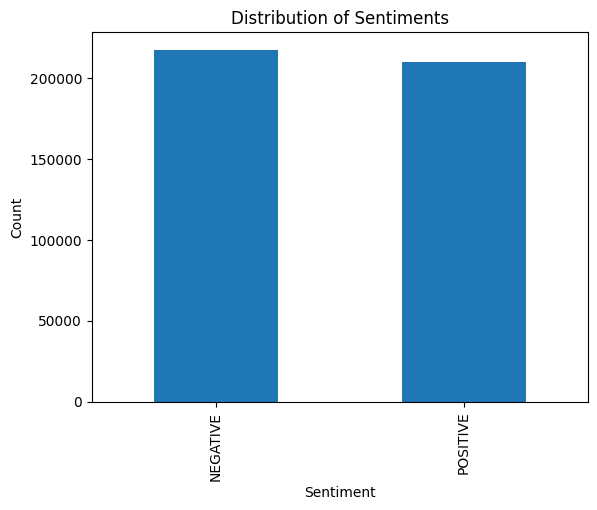

In [3]:
df['sentiment'].value_counts().plot(kind='bar')

plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

**Note:** We can see that the data is balanced

In [4]:
df.describe()

,neg,neu,pos,compound
count,427482.000000,427482.000000,427482.000000,427482.000000
mean,0.140294,0.742719,0.116985,0.243870
std,0.166470,0.162196,0.135587,0.623274
min,0.000000,0.000000,0.000000,-0.990800
25%,0.000000,0.672000,0.004264,-0.340000
50%,0.095000,0.782000,0.087000,0.361200
75%,0.207872,0.861000,0.167336,0.877805
max,1.000000,0.980000,1.000000,0.999887


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427482 entries, 0 to 427481
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       427482 non-null  object 
 1   news       427482 non-null  object 
 2   neg        427482 non-null  float64
 3   neu        427482 non-null  float64
 4   pos        427482 non-null  float64
 5   compound   427482 non-null  float64
 6   sentiment  427482 non-null  object 
dtypes: float64(4), object(3)
memory usage: 22.8+ MB


**Note:** we can see that there is no null values in the data

In [6]:
num_duplicates = df.duplicated().sum()
num_duplicates

0

Let's explore the length of news 

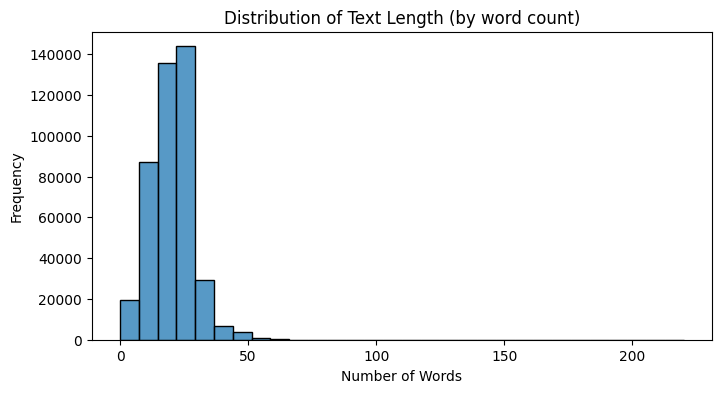

In [7]:
df['text_length'] = df['news'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,4))
sns.histplot(df['text_length'], bins=30, kde=False)
plt.title('Distribution of Text Length (by word count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

Top words Frequeincies

In [8]:
import re
import nltk
nltk.download('punkt_tab')  # Make sure to download 'punkt' for word_tokenize
from nltk.tokenize import word_tokenize
from collections import Counter
def simple_tokenize(text):
    """
    A simple tokenizer using NLTK word_tokenize.
    You could replace this with a more sophisticated approach
    (e.g., spaCy) if desired.
    """
    # Lowercase
    text = text.lower()
    # Remove extra characters (optional)
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    # Tokenize
    tokens = word_tokenize(text)
    return tokens

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [9]:
# Apply to entire DataFrame (you can store tokens in a new column if desired)
df['tokens'] = df['news'].apply(simple_tokenize)

# Separate out positive and negative texts for comparison
positive_texts = df[df['sentiment'] == 'POSITIVE']['tokens']
negative_texts = df[df['sentiment'] == 'NEGATIVE']['tokens']

# Flatten lists of tokens
pos_tokens_flat = [token for tokens in positive_texts for token in tokens]
neg_tokens_flat = [token for tokens in negative_texts for token in tokens]

pos_freq = Counter(pos_tokens_flat).most_common(10)
neg_freq = Counter(neg_tokens_flat).most_common(10)

print("\nTop 10 tokens in POSITIVE texts:")
for token, freq in pos_freq:
    print(f"{token}: {freq}")

print("\nTop 10 tokens in NEGATIVE texts:")
for token, freq in neg_freq:
    print(f"{token}: {freq}")


Top 10 tokens in POSITIVE texts:
the: 258245
a: 131220
to: 113047
of: 109812
and: 107395
in: 96406
for: 45696
on: 37930
is: 35349
with: 29360

Top 10 tokens in NEGATIVE texts:
the: 245402
a: 123574
of: 118805
to: 112295
in: 103918
and: 89328
for: 44211
on: 42139
is: 33232
that: 32516


**Note**: we can see that the words that are the most frequent words have no effects on the sentiment and they are stop words so we need to remove them in next step


Generating Word Clouds...


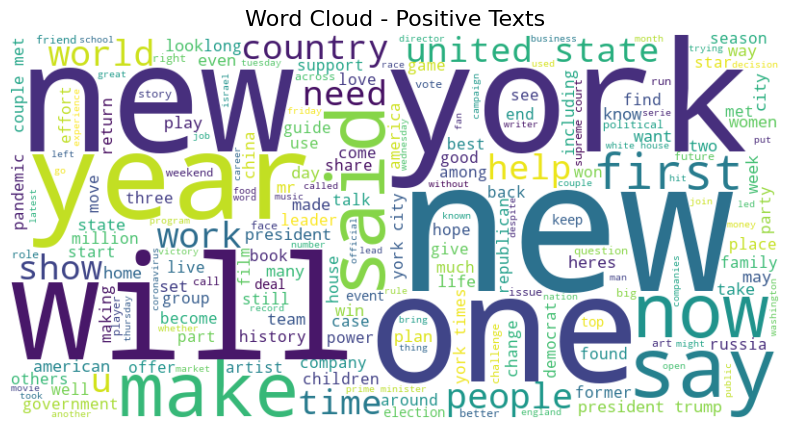

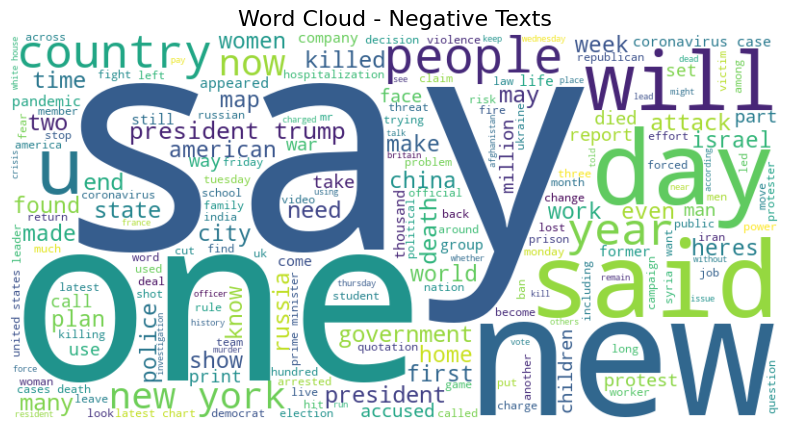

In [10]:
from wordcloud import WordCloud
def plot_wordcloud(token_list, title):
    """
    Given a list of tokens, generate and display a word cloud.
    """
    # Convert tokens to a single string
    text_string = " ".join(token_list)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

print("\nGenerating Word Clouds...")
plot_wordcloud(pos_tokens_flat, "Word Cloud - Positive Texts")
plot_wordcloud(neg_tokens_flat, "Word Cloud - Negative Texts")

In [11]:
from nltk.util import ngrams

def get_top_ngrams(token_list, n=2, top_k=10):
    """
    Compute top-k most common n-grams (for n=2 bigrams, n=3 trigrams, etc.).
    token_list should be a list of tokens (already cleaned).
    """
    # Generate n-grams
    n_grams = ngrams(token_list, n)
    freq_dist = Counter(n_grams)
    return freq_dist.most_common(top_k)

# Example: Top 10 bigrams in positive texts
pos_bigrams = get_top_ngrams(pos_tokens_flat, n=2, top_k=10)
print("\nTop 10 BIGRAMS in POSITIVE texts:")
for bigram, freq in pos_bigrams:
    print(f"{bigram}: {freq}")

# Example: Top 10 trigrams in negative texts
neg_trigrams = get_top_ngrams(neg_tokens_flat, n=3, top_k=10)
print("\nTop 10 TRIGRAMS in NEGATIVE texts:")
for trigram, freq in neg_trigrams:
    print(f"{trigram}: {freq}")



Top 10 BIGRAMS in POSITIVE texts:
('of', 'the'): 25364
('in', 'the'): 21140
('to', 'the'): 9252
('for', 'the'): 8728
('on', 'the'): 8457
('at', 'the'): 7896
('in', 'a'): 7776
('and', 'the'): 7673
('new', 'york'): 7521
('of', 'a'): 5810

Top 10 TRIGRAMS in NEGATIVE texts:
('of', 'the', 'day'): 3548
('the', 'day', 'for'): 2061
('quotation', 'of', 'the'): 2055
('in', 'print', 'on'): 2050
('the', 'end', 'of'): 2011
('of', 'coronavirus', 'cases'): 1906
('see', 'the', 'latest'): 1869
('the', 'latest', 'charts'): 1869
('coronavirus', 'cases', 'deaths'): 1868
('latest', 'charts', 'and'): 1867


# Data Cleaning

## Lower case the text

In [12]:
def lowecasing(text):
    return text.lower()
df['cleaned_text'] = df['news'].apply(lowecasing)
df.head()

,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text
0,2007-07-07,It was a long antipodean night. While there’s ...,0.059000,0.87800,0.064000,0.051600,POSITIVE,37,"[it, was, a, long, antipodean, night, while, t...",it was a long antipodean night. while there’s ...
1,2007-07-07,In Mexico there are no licensing or registrati...,0.044000,0.95600,0.000000,-0.296000,NEGATIVE,49,"[in, mexico, there, are, no, licensing, or, re...",in mexico there are no licensing or registrati...
2,2007-07-07,The government has until Monday to protect the...,0.000000,0.89400,0.106000,0.381800,POSITIVE,24,"[the, government, has, until, monday, to, prot...",the government has until monday to protect the...
3,2007-07-07,A record-breaking heat wave in the Southwest i...,0.197505,0.66149,0.141005,0.997491,POSITIVE,10,"[a, recordbreaking, heat, wave, in, the, south...",a record-breaking heat wave in the southwest i...
4,2007-07-07,England started its Live Earth concert at Wemb...,0.033000,0.94500,0.022000,-0.177900,NEGATIVE,65,"[england, started, its, live, earth, concert, ...",england started its live earth concert at wemb...


## Remove URLs, Hashtags,Imogies and Mentions

Let's check for mentions


In [ ]:
def check_mentions(text):
    mentions = re.findall(r'@\w+', text)
    return mentions
df['mentions'] = df['cleaned_text'].apply(check_mentions)



In [ ]:
df[df['mentions'].apply(len)>0]

,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text,mentions
9366,2009-06-17,"b""Attention Iranian Redditors! Help the Irania...",0.037000,0.858000,0.105000,0.574700,POSITIVE,50,"[battention, iranian, redditors, help, the, ir...","b""attention iranian redditors! help the irania...",[@x0rz]
23606,2011-01-09,"WARNING: all 637,000 @wikileaks followers are ...",0.173000,0.827000,0.000000,-0.482400,NEGATIVE,18,"[warning, all, 637000, wikileaks, followers, a...","warning: all 637,000 @wikileaks followers are ...",[@wikileaks]
24669,2011-02-20,"Protests now reach China, 13 cities joined the...",0.073000,0.885000,0.042000,-0.202300,NEGATIVE,26,"[protests, now, reach, china, 13, cities, join...","protests now reach china, 13 cities joined the...",[@junlinghu]
32420,2011-12-27,If you could tweet on behalf of your country -...,0.000000,0.941000,0.059000,0.250000,POSITIVE,33,"[if, you, could, tweet, on, behalf, of, your, ...",if you could tweet on behalf of your country -...,[@sweden]
36641,2012-06-13,Colbert asks for @sweden Twitter control. Swed...,0.185664,0.761395,0.052941,0.990141,NEGATIVE,10,"[colbert, asks, for, sweden, twitter, control,...",colbert asks for @sweden twitter control. swed...,[@sweden]
...,...,...,...,...,...,...,...,...,...,...,...
353720,2021-06-02,The TikTok creator known as @itsmetinx has gai...,0.000000,0.833000,0.167000,0.612400,POSITIVE,27,"[the, tiktok, creator, known, as, itsmetinx, h...",the tiktok creator known as @itsmetinx has gai...,[@itsmetinx]
366711,2021-09-03,The 18-year-old behind the viral Twitter accou...,0.054738,0.697639,0.247623,0.994491,NEGATIVE,19,"[the, 18yearold, behind, the, viral, twitter, ...",the 18-year-old behind the viral twitter accou...,[@craigweekend]
370888,2021-10-01,"With a deft plan, @BritneyLawArmy kept everyon...",0.011782,0.634827,0.353391,0.999327,POSITIVE,21,"[with, a, deft, plan, britneylawarmy, kept, ev...","with a deft plan, @britneylawarmy kept everyon...",[@britneylawarmy]
385780,2022-01-25,"In this lesson, students will consider what th...",0.022982,0.891179,0.085839,0.986479,POSITIVE,18,"[in, this, lesson, students, will, consider, w...","in this lesson, students will consider what th...",[@nyt_first_said]


**Note:** We can see that 67 samples cony=tain mentions so let's remove them

In [17]:
def remove_mentions(text):
    return re.sub(r'@\w+', '', text)
df.loc[df['mentions'].apply(len) > 0, 'cleaned_text'] = df.loc[df['mentions'].apply(len) > 0, 'cleaned_text'].apply(remove_mentions)

In [18]:
df['mentions'] = df['cleaned_text'].apply(check_mentions)
df[df['mentions'].apply(len)>0]


,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text,mentions


Let's check for urls

In [19]:
def check_urls(text):
    urls = re.findall(r'http\S+|www.\S+', text)
    return urls 
df['urls'] = df['cleaned_text'].apply(check_urls)
df[df['urls'].apply(len)>0]

,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text,mentions,urls
1449,2008-08-04,b'US$ 50 mil scam: www.beijing-tickets2008.com...,0.429000,0.571000,0.000000,-0.817600,NEGATIVE,13,"[bus, 50, mil, scam, wwwbeijingtickets2008com,...",b'us$ 50 mil scam: www.beijing-tickets2008.com...,[],"[www.beijing-tickets2008.com, www .beijingtick..."
6208,2009-02-10,b'Pedophile upset that victim\'s family would ...,0.277000,0.723000,0.000000,-0.657100,NEGATIVE,16,"[bpedophile, upset, that, victims, family, wou...",b'pedophile upset that victim\'s family would ...,[],"[wwww,]"
6786,2009-03-05,"b'This what I get when I go to YouTube: ""Dear ...",0.105000,0.753000,0.142000,0.202300,POSITIVE,43,"[bthis, what, i, get, when, i, go, to, youtube...","b'this what i get when i go to youtube: ""dear ...",[],[www.pta.gov.pk)]
8528,2009-05-15,b'Piratebay DDo$ attack site (http://interneta...,0.237000,0.763000,0.000000,-0.476700,NEGATIVE,11,"[bpiratebay, ddo, attack, site, httpinternetav...",b'piratebay ddo$ attack site (http://interneta...,[],[http://internetavgift.se/)]
14629,2010-01-13,b'Please go to www.redcross.org and donate at ...,0.000000,0.880000,0.120000,0.457400,POSITIVE,25,"[bplease, go, to, wwwredcrossorg, and, donate,...",b'please go to www.redcross.org and donate at ...,[],[www.redcross.org]
22707,2010-12-04,"Wikileaks is not dead, only the url. you can ...",0.000000,0.823000,0.177000,0.533400,POSITIVE,17,"[wikileaks, is, not, dead, only, the, url, you...","wikileaks is not dead, only the url. you can ...",[],[www.wikileaks.ch]
25523,2011-03-26,Microsoft Compromises Users Privacy: No HTTPS ...,0.196000,0.804000,0.000000,-0.296000,NEGATIVE,10,"[microsoft, compromises, users, privacy, no, h...",microsoft compromises users privacy: no https ...,[],[https]
33538,2012-02-10,Iran Begins Blocking Sites Using HTTPS Protoco...,0.111000,0.766000,0.123000,0.077200,POSITIVE,20,"[iran, begins, blocking, sites, using, https, ...",iran begins blocking sites using https protoco...,[],[https]
33559,2012-02-11,Iran partially blocks encrypted network traffi...,0.160000,0.840000,0.000000,-0.226300,NEGATIVE,11,"[iran, partially, blocks, encrypted, network, ...",iran partially blocks encrypted network traffi...,[],[https]
47805,2013-09-03,France release videos of Sarin Gas attack in S...,0.256000,0.744000,0.000000,-0.476700,NEGATIVE,10,"[france, release, videos, of, sarin, gas, atta...",france release videos of sarin gas attack in s...,[],[www.defense.gouv.fr]]


**Note:** We can see that there are 47 samples with URLs so let's process them

In [25]:
def remove_urls(text):
    return re.sub(r'http\S+|www.\S+', '', text)
df.loc[df['urls'].apply(len) > 0, 'cleaned_text'] = df.loc[df['urls'].apply(len) > 0, 'cleaned_text'].apply(remove_urls)

In [28]:
df['urls'] = df['cleaned_text'].apply(check_urls)
df[df['urls'].apply(len)>0]

,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text,mentions,urls
